# 📌 P3P with Kneip's Method — PyTorch Implementation Demo Step-by-Step

This notebook presents a Step-by-Step PyTorch-based implementation of the Perspective-Three-Point (P3P) problem using the approach described in the paper:

> **A Novel Parametrization of the Perspective-Three-Point Problem for a Direct Computation of Absolute Camera Position and Orientation**  
> by Laurent Kneip, Davide Scaramuzza, Roland Siegwart  

We follow the core idea of their method to compute the absolute pose (position and orientation) of a calibrated camera from 3 known 3D–2D point correspondences.

---

This demo is designed for educational and validation purposes, and uses synthetic data for full control over the geometry and ground truth.

In [3]:
import numpy as np 
import torch

### 🎯 Problem Setup

We are given:

- 📷 Camera intrinsics matrix **A** (includes focal length and principal point)
- 📌 3D world points **P₁**, **P₂**, **P₃** (and **P₄** used to disambiguate P3P solutions)
- 📍 Corresponding 2D image projections for these 3D points

Using this data, we compute the unit direction vectors (feature vectors) that point from the camera center toward each 3D point. These vectors are used as input to the P3P algorithm.

---

### 🧩 Objective

Estimate the camera's:

- 🔄 Rotation matrix **R** (camera orientation)
- 📍 Position (camera center) **C** in world coordinates


In [5]:
def camera() : 
  # Definition of the camera parameters
  # focal length
  fx = 800
  fy = 800
  # center
  cx = 320 
  cy = 240

  A = torch.tensor([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=torch.float64) # intraseca matrix of the camera (3*3)
  #A = torch.from_numpy(A)  # Convert to a PyTorch tensor
  print("A = \n", A)
  print(A.shape)  # (3*3)
  return A

A = camera() 


def rotation_matrix() : 
  # Definition of the rotation matrix of the camera 
  R = torch.tensor([[1, 0, 0],[0, -1, 0], [0, 0, -1]], dtype=torch.float64)  # (3*3)
  #R = torch.from_numpy(R)  # Convert to a PyTorch tensor
  print("R = \n",R)
  print(R.shape)  # (3*3)
  return R

def camera_position() : 
  # Definition of the translation matrix of the camera (the position)
  C = torch.tensor([[0,0,6]], dtype=torch.float64)    # T = [tx,ty,tz]  (1*3)

  print("C = \n",C)
  print(C.shape)  # (1*3)
  return C

R = rotation_matrix()
C = camera_position()

A = 
 tensor([[800.,   0., 320.],
        [  0., 800., 240.],
        [  0.,   0.,   1.]], dtype=torch.float64)
torch.Size([3, 3])
R = 
 tensor([[ 1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0., -1.]], dtype=torch.float64)
torch.Size([3, 3])
C = 
 tensor([[0., 0., 6.]], dtype=torch.float64)
torch.Size([1, 3])


### 🧪 Step 2: Generate Synthetic Data

To validate our P3P implementation in a controlled environment, we generate synthetic data:

-  Create 3 3D points in world coordinates
- 📷 based on the predefined rotation matrix (R) and position (C)
- 🔁 Use the camera projection model to project the 3D points onto the image plane:
  
$$\textbf{p}_i = A [R \,|\, -RC] \cdot \textbf{P}_i$$

where $\textbf{p}_i$ is the corresponding 2D point of the 3D point $\textbf{P}_i$

-  Normalize the projected 2D points (homogeneous division)
- ✅ Store the resulting 2D coordinates as the observed image points

This synthetic setup allows us to test our algorithm without noise or real-world uncertainties.

> ℹ️ Note: In real-world scenarios, the camera pose (R, C) is unknown and must be estimated. The corresponding 2D image points are typically obtained using feature detection and matching methods (e.g., SIFT, ORB, COLMAP, etc.).  
> This step of obtaining 2D–3D correspondences is a necessary preprocessing stage before applying any P3P algorithm.

This synthetic setup allows us to test our algorithm without noise or real-world uncertainties.

In [27]:
import torch
import torch.nn.functional as F

# Set print precision for better readability
torch.set_printoptions(precision=4, sci_mode=False)

# Define 3D points in world coordinates
P1 = [0.7161, 0.5431, 1.7807]
P2 = [-1.1643, 0.8371, -1.0551]
P3 = [-1.5224, 0.4292, -0.1994]

# Stack the 3D points into a tensor (shape 3x3)
points3D = torch.tensor([P1, P2, P3], dtype=torch.float64).T
print("3D points (shape 3x3):\n", points3D)

# Compute camera translation vector from rotation R and position C
t = -R @ torch.reshape(C, (3, 1))

# Build projection matrix: P = K [R|t]
Rt = torch.cat([R, t], dim=1)
P = A @ Rt

# Convert 3D points to homogeneous coordinates (4x3)
points3D_h = torch.cat([points3D, torch.ones(1, 3, dtype=torch.float64)], dim=0)

# Project 3D points to 2D image plane using projection matrix
proj = P @ points3D_h
proj = proj / proj[2, :]  # normalize homogeneous coordinates

# Extract 2D image coordinates (3 points, shape 3x2)
points2D = proj[:2, :].T

# Display projection matrix and 2D image points
print("Projection matrix P:\n", P)
print("Projected corresponding 2D points:\n", points2D)

3D points (shape 3x3):
 tensor([[ 0.7161, -1.1643, -1.5224],
        [ 0.5431,  0.8371,  0.4292],
        [ 1.7807, -1.0551, -0.1994]], dtype=torch.float64)
Projection matrix P:
 tensor([[       800.,          0.,       -320.,       1920.],
        [         0.,       -800.,       -240.,       1440.],
        [         0.,          0.,         -1.,          6.]],
       dtype=torch.float64)
Projected corresponding 2D points:
 tensor([[455.7761, 137.0256],
        [187.9764, 145.0786],
        [123.5423, 184.6140]], dtype=torch.float64)


### 🔹 Step 2 — Compute Feature Vectors (Unit Bearing Vectors)

This block of code:

- Takes the resulting 2D pixel coordinates and transforms them into 3D unit vectors in the camera frame.
- For each image point:

  - Converts it to homogeneous coordinates. (so adds a dummy dimension)
  - Applies the inverse of the intrinsic matrix $A^{-1}$ to back-project the 2D points into the camera frame.
  - Normalizes the result to obtain a unit direction vector pointing toward the 3D point.

This matches exactly what the Kneip et al. P3P paper assumes:

> “We assume that the unitary vectors f₁, f₂, and f₃—pointing toward the three considered feature points from the camera frame—are given.”

In [ ]:
f_list = []

for p in points2D:
    # Convert to homogeneous coordinates: (x, y) → (x, y, 1)
    p_h = torch.cat([p, torch.tensor([1.0], dtype=torch.float64)])

    # Apply inverse of intrinsic matrix to get direction vector in camera frame
    f = torch.linalg.inv(A) @ p_h

    # Normalize to get a unit vector (bearing direction)
    f = f / torch.norm(f)

    f_list.append(f)

# Stack into a matrix: shape (3, 3) where each column is f1, f2, f3
f_matrix = torch.stack(f_list, dim=1)

f1 = f_matrix[:, 0]
f2 = f_matrix[:, 1]
f3 = f_matrix[:, 2]

featuresVect = [f1, f2, f3]
print("Features vector (shape 3x3):\n", featuresVect)


Features vector (shape 3x3):
 [tensor([ 0.1660, -0.1259,  0.9781], dtype=torch.float64), tensor([-0.1617, -0.1163,  0.9800], dtype=torch.float64), tensor([-0.2379, -0.0671,  0.9690], dtype=torch.float64)]


✅ In the end, we have:

- 3 known 3D points in world coordinates: $P_1, P_2, P_3$
- 3 unit feature vectors in the camera frame: $\vec{f}_1, \vec{f}_2, \vec{f}_3$

➡️ These are the two inputs required by the P3P algorithm as formulated by Kneip et al.

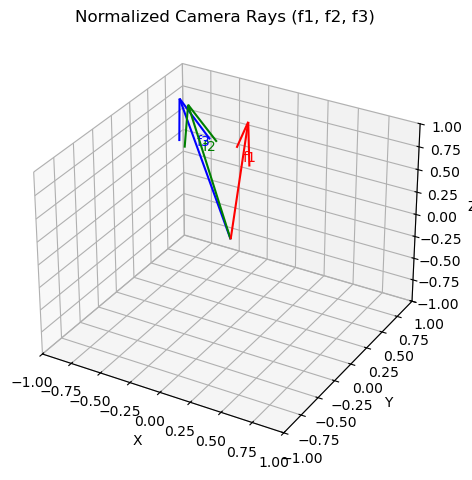

In [21]:
import matplotlib.pyplot as plt
# Plot rays in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b']

for i, ray in enumerate(featuresVect):
    ax.quiver(0, 0, 0, ray[0], ray[1], ray[2], color=colors[i], length=1.5, normalize=True)
    ax.text(ray[0], ray[1], ray[2], f"f{i+1}", color=colors[i])

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Normalized Camera Rays (f1, f2, f3)")
plt.tight_layout()
plt.show()

#### 🧮 Polynomial Root Solvers for P3P

To complete the Kneip P3P pipeline, we need to solve polynomials of degree 3 and 4. The following functions implement:

- A cubic root solver (required as part of Ferrari's method)
- A 4th-degree root solver using Ferrari’s method


In [41]:
from complex_utils import *

def polynomial_root_calculation_3rd_degree(a, b, c, d):
    '''# Convert to complex tensors
    a = torch.tensor(a, dtype=torch.complex64)
    b = torch.tensor(b, dtype=torch.complex64)
    c = torch.tensor(c, dtype=torch.complex64)
    d = torch.tensor(d, dtype=torch.complex64)'''

    # Discriminant terms
    p = (3 * a * c - b**2) / (3 * a**2)
    q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)
    delta = -4 * p**3 - 27 * q**2
    roots = []

    j_ = torch.tensor([-0.5, torch.sqrt(torch.tensor(3))/2])  # cube root of unity

    for k in range(3):
        delta_sur_27 = -delta / 27          # reéls

        sqrt_term = sqrt(delta_sur_27)  # Use the sqrt function defined above
        u_k = product_of_2_complex_numbers(complex_number_power_k(j_,k), sqrt_3(torch.tensor([0.5*(-q+sqrt_term[0]),sqrt_term[1]])) )# because q real 
        v_k = product_of_2_complex_numbers(complex_number_power_k(j_,-k), sqrt_3(torch.tensor([0.5*(-q-sqrt_term[0]),-0.5*sqrt_term[1]])))

        root = addition(addition(u_k, v_k), torch.tensor([-b/(3*a),0]) ) 
        roots.append(root)

    return torch.stack(roots)

def polynomial_root_calculation_4th_degree_ferrari(a): # Ferrari's Method
    # Solving a polynomial of 4th degree

    # Input : array 5*1 with the 5 coefficiants of the polynomial 
    # Output : roots of the polynomial a[4]*x^4 + a[3]*x^3 + a[2]*x^2 + a[1]*x + a[0]   -> array : [x1,x2,x3,x4]  (4*1)

    if a.numel() != 5 :
      print("Expeted 5 coefficiants for a 4th order polynomial")
      return

    a0, a1, a2, a3, a4 = a      # float

    # Reduce the quartic equation to the form : x^4 + a*x^3 + b*x^2 + c*x + d = 0
    a = a3/a4           # float 
    b = a2/a4
    c = a1/a4
    d = a0/a4

    # Computation of the coefficients of the Ferrari's Method
    S = a/4
    b0 = d - c*S + b* S**2 - 3* S**4
    b1 = c - 2*b*S + 8*S**3
    b2 = b - 6 * S**2


    # Solve the cubic equation m^3 + b2*m^2 + (b2^2/4  - b0)*m - b1^2/8 = 0
    x_cube = polynomial_root_calculation_3rd_degree(1,b2,(b2**2)/4-b0,(-b1**2)/8)
    

    # Find a real and positive solution
    alpha_0_nul = True
    for r in x_cube :
      if torch.isclose(r[1],torch.tensor(0.0,dtype=torch.float64),atol=1e-7) and r[0] > 0 :
        alpha_0 = r
        alpha_0_nul = False
        

    if alpha_0_nul == False :   # case where we found a real and positive solution so alpha_0_imag = 0 
        alpha0_div_2 = product_complex_real(alpha_0,0.5)
        sqrt_alpha = sqrt(alpha0_div_2[0])
        term = addition_complex_real(- alpha0_div_2 ,-b2 / 2)
        denom = 2 * torch.sqrt(2 * alpha_0)
        
       
        frac = division_2_complex_numbers(torch.tensor([b1, 0.0]), denom)  # b1 is real, so we can use a tensor with 0 imaginary part

        x1 = addition_complex_real(sqrt_alpha ,- S) + sqrt_complex(addition(term,-frac))
        x2 = addition_complex_real(sqrt_alpha, - S) - sqrt_complex(addition(term,-frac))
        x3 = addition_complex_real(-sqrt_alpha, - S) + sqrt_complex(addition(term,frac))
        x4 = addition_complex_real(-sqrt_alpha,- S) - sqrt_complex(addition(term,frac))
    
    else:

        sqrt_inner1 = sqrt((b2**2) / 4 - b0)        # complex 
        x1 = addition_complex_real(sqrt_complex(addition_complex_real(sqrt_inner1,-b2 / 2)),-S)
        x2 = addition_complex_real(- sqrt_complex(addition_complex_real(sqrt_inner1,-b2 / 2)),-S)
        x3 = addition_complex_real(sqrt_complex(addition_complex_real(- sqrt_inner1,-b2 / 2 )),-S)
        x4 = addition_complex_real(- sqrt_complex(addition_complex_real(- sqrt_inner1,-b2 / 2 )),-S)

    return [x1, x2, x3, x4]


## P3P Solution Workflow

Now that we have all the required variables (3D points and feature vectors), we can proceed with the P3P pipeline following Kneip’s method:


### 1. Store 3D Points  
Already defined as:  
- P₁, P₂, P₃ ∈ ℝ³

In [28]:
P1 = torch.tensor([0.7161, 0.5431, 1.7807], dtype=torch.float64)
P2 = torch.tensor([-1.1643, 0.8371, -1.0551], dtype=torch.float64)
P3 = torch.tensor([-1.5224, 0.4292, -0.1994], dtype=torch.float64)

### 2. Store Feature Vectors  
Already defined as:  
- f₁, f₂, f₃ ∈ ℝ³  
These are the unit direction vectors from the camera center toward each 3D point, expressed in the camera frame.


In [29]:
# we got featuresVect and we access the 3 values 
f1 = featuresVect[0]
f2 = featuresVect[1]
f3 = featuresVect[2]

print("f1 = ", f1)
print(f1.shape)  # (3,)
print("f2 = ", f2)
print("f3 = ", f3)

f1 =  tensor([ 0.1660, -0.1259,  0.9781], dtype=torch.float64)
torch.Size([3])
f2 =  tensor([-0.1617, -0.1163,  0.9800], dtype=torch.float64)
f3 =  tensor([-0.2379, -0.0671,  0.9690], dtype=torch.float64)


### 3. 📦 Initialize Solution Storage  
There can be up to 4 valid P3P solutions.  
We store them in a tensor of shape:

$$
\texttt{solutions} \in \mathbb{R}^{4 \times 3 \times 4}
$$

Each slice corresponds to one solution:

- First column (3×1): estimated camera position vector C
- Remaining columns (3×3): estimated rotation matrix R


In [30]:
solutions = torch.zeros((4,3,4), dtype=torch.float64)
print("solutions = \n", solutions)
print(solutions.shape)  # (4,3,4)

solutions = 
 tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float64)
torch.Size([4, 3, 4])


### 4. ❗ Check for Collinearity  
Ensure the three 3D points are not collinear:

$$
(P_2 - P_1) \times (P_3 - P_1) \neq 0
$$


In [31]:
# Test of non-collinearity
v1 = P2 - P1
v2 = P3 - P1
if torch.norm(torch.cross(v1,v2, dim=0))==0 :
    print('Problem: the points must not be collinear')
else:
    print('The points are not collinear, we can continue')

The points are not collinear, we can continue


### 5. Build Orthonormal Frame in the Image Space

To simplify the geometric relationships between the feature direction vectors $\mathbf{f}_1$, $\mathbf{f}_2$, and $\mathbf{f}_3$, we construct an orthonormal basis in the image frame. This local right-handed coordinate system helps reduce the complexity of the subsequent trigonometric calculations.

The basis vectors are defined as follows:

- $\mathbf{e}_1 = \mathbf{f}_1$: the first basis vector is aligned with the direction of the first feature.
- $\mathbf{e}_3 = \frac{\mathbf{f}_1 \times \mathbf{f}_2}{\| \mathbf{f}_1 \times \mathbf{f}_2 \|}$: the third basis vector is the normalized cross product of $\mathbf{f}_1$ and $\mathbf{f}_2$, pointing perpendicular to the plane they define.
- $\mathbf{e}_2 = \mathbf{e}_3 \times \mathbf{e}_1$: the second basis vector completes the orthonormal frame, ensuring a right-handed orientation.

These three vectors form the matrix $\mathbf{T} \in \mathbb{R}^{3 \times 3}$, which transforms any vector into this new coordinate system:

$$
\mathbf{T} =
\begin{bmatrix}
\mathbf{e}_1^\top \\
\mathbf{e}_2^\top \\
\mathbf{e}_3^\top
\end{bmatrix}.
$$

In particular, we will use $\mathbf{T}$ to express $\mathbf{f}_3$ in this image-aligned frame:

$$
\mathbf{f}_3^\tau = \mathbf{T} \mathbf{f}_3.
$$

In [33]:
# Calculation of vectors of the base τ = (C,tx,ty,tz)
tx = f1     
print("tx = ", tx)
print(tx.shape)  # (3,)
tz = torch.cross(f1,f2, dim=0)/torch.norm(torch.cross(f1,f2, dim=0))
print("tz = ", tz)
ty = torch.cross(tz,tx, dim=0)
print("ty = ", ty)

tx =  tensor([ 0.1660, -0.1259,  0.9781], dtype=torch.float64)
torch.Size([3])
tz =  tensor([-0.0298, -0.9920, -0.1226], dtype=torch.float64)
ty =  tensor([-0.9857,  0.0088,  0.1684], dtype=torch.float64)


Display for the verification of non-collinearity of the 3 vectors 

tx = tensor([ 0.1660, -0.1259,  0.9781], dtype=torch.float64)
ty = tensor([-0.9857,  0.0088,  0.1684], dtype=torch.float64)
tz = tensor([-0.0298, -0.9920, -0.1226], dtype=torch.float64)

Vérification orthogonalité :
tx · ty = 8.859421496842888e-18
tx · tz = 1.3662951446253552e-17
ty · tz = 1.6912364970920158e-19


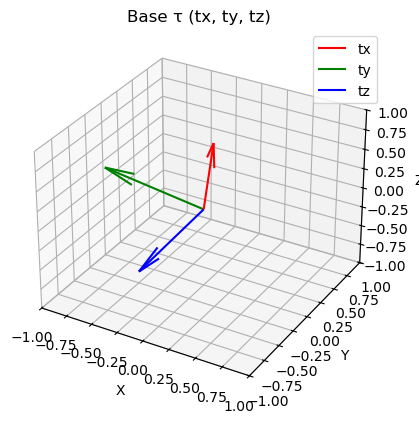

In [34]:
import numpy as np
import matplotlib.pyplot as plt
print("tx =", tx)
print("ty =", ty)
print("tz =", tz)

print("\nVérification orthogonalité :")
print("tx · ty =", np.dot(tx, ty))
print("tx · tz =", np.dot(tx, tz))
print("ty · tz =", np.dot(ty, tz))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

origin = np.zeros(3)

ax.quiver(*origin, *tx, color='r', label='tx')
ax.quiver(*origin, *ty, color='g', label='ty')
ax.quiver(*origin, *tz, color='b', label='tz')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Base τ (tx, ty, tz)')
ax.legend()
plt.show()


In [35]:
tx = torch.reshape(tx,(1,3))   # (1*3)
ty = torch.reshape(ty,(1,3))
tz = torch.reshape(tz,(1,3))

# Computation of the matrix T and the feature vector f3
T = torch.cat((tx,ty,tz),dim = 0) # (3*3)
f3_T = torch.tensordot(T,f3, dims=1) # (3,)

print("tx = \n", tx)
print(tx.shape)  # (1*3)
print("ty = \n", ty)
print("tz = \n", tz)
print("f3_T = \n", f3_T)
print(f3_T.shape)  # (3,)
print("T = \n", T)
print(T.shape)  # (3,3)

tx = 
 tensor([[ 0.1660, -0.1259,  0.9781]], dtype=torch.float64)
torch.Size([1, 3])
ty = 
 tensor([[-0.9857,  0.0088,  0.1684]], dtype=torch.float64)
tz = 
 tensor([[-0.0298, -0.9920, -0.1226]], dtype=torch.float64)
f3_T = 
 tensor([ 0.9166,  0.3971, -0.0452], dtype=torch.float64)
torch.Size([3])
T = 
 tensor([[ 0.1660, -0.1259,  0.9781],
        [-0.9857,  0.0088,  0.1684],
        [-0.0298, -0.9920, -0.1226]], dtype=torch.float64)
torch.Size([3, 3])


In [36]:
f3_T_positif = False

# Having teta in [ 0, pi ] 
if f3_T[2] > 0 :
    f3_T_positif = True
   

### 6. Build Orthonormal Frame in the World Space

To analyze the 3D geometry in a local coordinate system aligned with the known world points, we construct an orthonormal basis denoted by $\eta = (\mathbf{n}_x, \mathbf{n}_y, \mathbf{n}_z)$. This basis will serve as a frame attached to the world points $\mathbf{P}_1, \mathbf{P}_2, \mathbf{P}_3$, and will simplify the relation between world and camera coordinates.

The construction proceeds as follows:
- We define the first axis as the unit vector from $\mathbf{P}_1$ to $\mathbf{P}_2$:
$
\mathbf{n}_x = \frac{\mathbf{P}_2 - \mathbf{P}_1}{|\mathbf{P}_2 - \mathbf{P}_1|}.
$
- Then, we compute the normal to the plane formed by the three world points using a cross product:
$
\mathbf{n}_z = \frac{\mathbf{n}_x \times (\mathbf{P}_3 - \mathbf{P}_1)}{|\mathbf{n}_x \times (\mathbf{P}_3 - \mathbf{P}_1)|}.
$
- The third axis is obtained by completing the right-handed frame:
$
\mathbf{n}_y = \mathbf{n}_z \times \mathbf{n}_x.
$

These three orthonormal vectors are then arranged as rows to define the transformation matrix $\mathbf{N} \in \mathbb{R}^{3 \times 3}$:
$$
\mathbf{N} =
\begin{bmatrix}
\mathbf{n}_x^\top \
\mathbf{n}_y^\top \
\mathbf{n}_z^\top
\end{bmatrix}.
$$

Finally, the 3D point $\mathbf{P}_3$ is expressed in this new world-aligned coordinate frame by subtracting the origin $\mathbf{P}_1$ and applying the transformation:
$
\mathbf{P}_3^\eta = \mathbf{N} (\mathbf{P}_3 - \mathbf{P}_1).
$

This change of basis simplifies subsequent computations, such as aligning world and image vectors to solve the P3P pose estimation problem.

In [37]:
# Calculation of vectors of the base η = (P1,nx,ny,nz)
nx = (P2 - P1)/torch.norm(P2 - P1)      #(3,)
nz = torch.cross(nx,P3-P1)/torch.norm(torch.cross(nx,P3-P1), dim=0)  
ny = torch.cross(nz,nx)
print("nx = ", nx)
print(nx.shape)  # (3,)
print("ny = ", ny)
print("nz = ", nz)

# Reshape the vectors to (1,3) for concatenation
nx = torch.reshape(nx,(1,3))  # (1,3)
ny = torch.reshape(ny,(1,3))
nz = torch.reshape(nz,(1,3))
print("nx = \n", nx)
print(nx.shape)  # (1*3)
print("ny = \n", ny)
print("nz = \n", nz)

# Computation of the matrix N and the world point P3
N = torch.cat((nx,ny,nz),dim = 0) # (3*3) T's equivalent in the world coordinate system

P3_n = torch.tensordot(N,P3-P1, dims=1) # (3,)

print("N = \n", N)
print(N.shape)  # (3,3)
print("P3_n = \n", P3_n)
print(P3_n.shape)  # (3,)


nx =  tensor([-0.5506,  0.0861, -0.8303], dtype=torch.float64)
torch.Size([3])
ny =  tensor([-0.7747, -0.4233,  0.4698], dtype=torch.float64)
nz =  tensor([-0.3110,  0.9019,  0.2998], dtype=torch.float64)
nx = 
 tensor([[-0.5506,  0.0861, -0.8303]], dtype=torch.float64)
torch.Size([1, 3])
ny = 
 tensor([[-0.7747, -0.4233,  0.4698]], dtype=torch.float64)
nz = 
 tensor([[-0.3110,  0.9019,  0.2998]], dtype=torch.float64)
N = 
 tensor([[-0.5506,  0.0861, -0.8303],
        [-0.7747, -0.4233,  0.4698],
        [-0.3110,  0.9019,  0.2998]], dtype=torch.float64)
torch.Size([3, 3])
P3_n = 
 tensor([    2.8668,     0.8521,     0.0000], dtype=torch.float64)
torch.Size([3])


### 7.  Compute Intermediate Variables  
These are required for the polynomial setup, we have : 
- $\phi_1 = \frac{f_{3,x}^\tau}{f_{3,z}^\tau}$ and $\phi_2 = \frac{f_{3,y}^\tau}{f_{3,z}^\tau}$ 
They represent the tangent of the angles that $\mathbf{f}_3$ makes with the x-axis and y-axis in the image frame (normalized by its z-component). These ratios are used to reduce the 3D geometry into a planar formulation.

- we extract the first two components of $\mathbf{P}_3^\eta$, the coordinates of point $\mathbf{P}_3$ in the world-aligned frame $p_1 = (\mathbf{P}_3^\eta)_x$ and $p_2 = (\mathbf{P}_3^\eta)_y$ that locate $\mathbf{P}_3$ in the local plane defined by $\mathbf{P}_1$ and $\mathbf{P}_2$ in the world.

- Computation of the distance between the two known world points $\mathbf{P}_1$ and $\mathbf{P}_2$ - $d_{12} = | \mathbf{P}_2 - \mathbf{P}_1 |$

- Computation of the cosine of the angle $\beta$ between the two image direction vectors $\mathbf{f}_1$ and $\mathbf{f}_2$ 
- Then computation of its cotangent using the identity:
$\cot(\beta) = \frac{\cos(\beta)}{\sqrt{1 - \cos^2(\beta)}}$

Finally if the angle $\beta$ is obtuse ($\cos(\beta) < 0$), we flip the sign of $b$.

In [ ]:
# Computation of phi1 et phi2 with 0=x, 1=y, 2=z
phi1 = f3_T[0]/f3_T[2]
phi2 = f3_T[1]/f3_T[2]
print("phi1 = ", phi1)
print("phi2 = ", phi2)

# Extraction of p1 and p2 from P3_eta
p1 = P3_n[0] #x
p2 = P3_n[1] #y
print("p1 = ", p1)
print("p2 = ", p2)

# Computation of d12
d12 = torch.norm(P2-P1) 
print("d12 = ", d12)

# Computation of b = cot(beta)
cosBeta = torch.dot(f1,f2)/(torch.norm(f1)*torch.norm(f2)) 
print("cosBeta = ", cosBeta)  
b = torch.sqrt(1/(1-cosBeta**2)-1)

if cosBeta < 0 :
    b = -b
print("b = ", b)

phi1 =  tensor(-20.2913, dtype=torch.float64)
phi2 =  tensor(-8.7914, dtype=torch.float64)
p1 =  tensor(2.8668, dtype=torch.float64)
p2 =  tensor(0.8521, dtype=torch.float64)
d12 =  tensor(3.4153, dtype=torch.float64)
cosBeta =  tensor(0.9463, dtype=torch.float64)
b =  tensor(2.9257, dtype=torch.float64)


### 8. Compute Quartic Polynomial Coefficients

Using the previously computed values, we compute the coefficients of a 4th-degree polynomial:

$$a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0 = 0$$

These coefficients are derived analytically from the geometric constraints of the P3P problem (as shown in Kneip's paper). This quartic equation will yield possible values of cos(θ), where θ is a rotation parameter used to recover pose.



In [39]:
a4 = - phi2**2 * p2**4 - phi1**2 * p2**4 - p2**4
a3 = 2 * p2**3 * d12 * b + 2 * phi2**2 * p2**3 * d12 * b - 2 * phi1 * phi2 * p2**3 * d12
a2 = - phi2**2 * p1**2 * p2**2 - phi2**2 * p2**2 * d12**2 * b**2 - phi2**2 * p2**2 * d12**2 + phi2**2 * p2**4 + phi1**2 * p2 **4 + 2 * p1 * p2**2 * d12 + 2 * phi1 * phi2 * p1 * p2**2 * d12 * b - phi1**2 * p1**2 * p2**2 + 2 * phi2**2 * p1 * p2**2 * d12 - p2**2 * d12**2 * b**2 - 2 * p1**2 * p2**2
a1 = 2 * p1**2 * p2 * d12 * b + 2 * phi1 * phi2 * p2**3 * d12 - 2 * phi2**2 * p2**3 * d12 * b - 2 * p1 * p2 * d12**2 * b
a0 = - 2 * phi1 * phi2 * p1 * p2**2 * d12 * b + phi2**2 * p2**2 * d12**2 + 2 * p1**3 * d12 - p1**2 * d12**2 + phi2**2 * p1**2 * p2**2 - p1**4 - 2 * phi2**2 * p1 * p2**2 * d12 + phi1**2 * p1**2 * p2**2 + phi2**2 * p2**2 * d12**2 * b**2

print("a4 = ", a4)
print("a3 = ", a3)
print("a2 = ", a2)
print("a1 = ", a1)
print("a0 = ", a0)


a4 =  tensor(-258.3021, dtype=torch.float64)
a3 =  tensor(214.0641, dtype=torch.float64)
a2 =  tensor(-468.5401, dtype=torch.float64)
a1 =  tensor(-228.4748, dtype=torch.float64)
a0 =  tensor(653.6391, dtype=torch.float64)


### 9. Solve the Quartic Polynomial

Use a robust method such as Ferrari’s formula to find the real roots of the polynomial:

- Solve the equation:$a_4 x^4 + a_3 x^3 + a_2 x^2 + a_1 x + a_0 = 0$
- Retain only the real-valued roots (ignore complex ones)

Each valid root represents a potential solution (i.e., a value for cos(θ)) that satisfies the P3P geometric constraints.


In [44]:
# Computation of the roots
roots = polynomial_root_calculation_4th_degree_ferrari(torch.tensor([a0,a1,a2,a3,a4])) # (4,)

print("roots = \n", roots)  # list of tensor (for complex numbers)


roots = 
 [tensor([0.4313, 1.6044], dtype=torch.float64), tensor([ 0.4313, -1.6044], dtype=torch.float64), tensor([0.9407, 0.0000], dtype=torch.float64), tensor([-0.9746, -0.0000], dtype=torch.float64)]


### 10. Back-substitute and Recover Pose

After solving the quartic polynomial, each real root gives a possible value for $\cos(\theta)$. For each such valid root, we reconstruct the corresponding camera pose (position and orientation) using the following steps:
1. Recover $\theta$ by Computing $\sin(\theta)$ given a real solution $\cos(\theta)$, compute:
$
\sin(\theta) = \sqrt{1 - \cos^2(\theta)}
$
2. Compute Angle $\alpha$ via $\cot(\alpha)$ from the previous geometric parameters:

$$
\cot(\alpha) = \frac{ \left( \frac{\phi_1}{\phi_2} \right) p_1 + \cos(\theta) p_2 - d_{12} b }{ \left( \frac{\phi_1}{\phi_2} \right) \cos(\theta) p_2 - p_1 + d_{12} }
$$

Then deduce:

$$
\sin(\alpha) = \sqrt{ \frac{1}{\cot^2(\alpha) + 1} }, \quad 
\cos(\alpha) = \sqrt{ 1 - \sin^2(\alpha) }
$$

> If $ \cot(\alpha) < 0 $, then set $ \cos(\alpha) := -\cos(\alpha) $


3. Compute the Camera Center (Intermediate and Absolute) expressed in the world base (intermediate form):

$$
\mathbf{C}_{\text{intermediate}} = d_{12} \cdot
\begin{bmatrix}
\cos(\alpha)(\sin(\alpha)b + \cos(\alpha)) \\
\sin(\alpha)\cos(\theta)(\sin(\alpha)b + \cos(\alpha)) \\
\sin(\alpha)\sin(\theta)(\sin(\alpha)b + \cos(\alpha))
\end{bmatrix}
$$

Transform it back to the global world frame using the world base $\mathbf{N}$:

$$
\mathbf{C}_{\text{est}} = \mathbf{P}_1 + \mathbf{N}^\top \cdot \mathbf{C}_{\text{intermediate}}
$$

---

4. Compute the Rotation Matrix

Construct the intermediate rotation matrix $ \mathbf{Q} $:

$$
\mathbf{Q} =
\begin{bmatrix}
-\cos(\alpha) & -\sin(\alpha)\cos(\theta) & -\sin(\alpha)\sin(\theta) \\
\sin(\alpha) & -\cos(\alpha)\cos(\theta) & -\cos(\alpha)\sin(\theta) \\
0 & -\sin(\theta) & \cos(\theta)
\end{bmatrix}
$$

Then compute the full rotation matrix in world coordinates:

$$
\mathbf{R}_{\text{est}} = \mathbf{N}^\top \cdot \mathbf{Q}^\top \cdot \mathbf{T}
$$

5. Store Solution

Each solution is saved in a tensor of shape $(4, 3, 4)$, where:

- The **first column** of each slice holds the estimated camera center $\mathbf{C}_{\text{est}}$
- The **last three columns** form the rotation matrix $\mathbf{R}_{\text{est}}$

Up to 4 possible solutions are generated. A fourth point $\mathbf{P}_4, \mathbf{p}_4$ can later be used to identify the correct one by checking reprojection error.

In [45]:
# For each solution of the polynomial
for i in range(4):
  #if np.isclose(np.imag(roots[i]),0) : # if real solution 

    # Computation of trigonometrics forms
    cos_teta = torch.tensor(roots[i][0])# real part of the root 
    sin_teta = torch.sqrt(1-cos_teta**2)

    cot_alpha = ((phi1/phi2)*p1 + cos_teta*p2 -d12*b )/ ((phi1/phi2)*cos_teta* p2 - p1 + d12)

    sin_alpha = torch.sqrt(1/(cot_alpha**2+1))
    cos_alpha= torch.sqrt(1-sin_alpha**2)

    if cot_alpha < 0 :
      cos_alpha = -cos_alpha

    # Computation of the intermediate rotation's matrixs
    C_estimate = torch.tensor([d12*cos_alpha*(sin_alpha*b + cos_alpha), d12*sin_alpha*cos_teta*(sin_alpha*b+cos_alpha), d12*sin_alpha*sin_teta*(sin_alpha*b+cos_alpha)]) # (3,)
    print("C_estimate = \n", C_estimate)
    print(C_estimate.shape)  # (3,)
    Q = torch.tensor([[-cos_alpha, -sin_alpha*cos_teta, -sin_alpha*sin_teta], [sin_alpha, -cos_alpha*cos_teta, -cos_alpha*sin_teta], [0, -sin_teta, cos_teta]])    # (3*3)
    print("Q = \n", Q)
    print(Q.shape)  # (3,3)
    # Computation of the absolute camera center
  
    C_estimate = P1 + torch.tensordot(torch.transpose(N, 0,1), C_estimate, dims=1) # (3,)
    print("C_estimate = \n", C_estimate) 
    print(C_estimate.shape)  # (3,)
    C_estimate = torch.reshape(C_estimate, (3,1))  # Reshape to (3,1) for consistency
    print("C_estimate = \n", C_estimate)  # (3,1)
    print("C_estimate.shape = ", C_estimate.shape)  # (3,1)

    # Computation of the orientation matrix
    R_estimate = torch.tensordot(torch.tensordot(torch.transpose(N,0,1),torch.transpose(Q, 0,1), dims=1),T,dims=1)   # (3*3)
    print("R_estimate = \n", R_estimate)
    print(R_estimate.shape)  # (3,3)
    
    # Adding C and R to the solutions
    solutions[i,:,:1]= C_estimate
    solutions[i,:,1:] = R_estimate

print("solutions = \n", solutions)


C_estimate = 
 tensor([-1.0076,  0.2018,  0.4222], dtype=torch.float64)
torch.Size([3])
Q = 
 tensor([[ 0.9070, -0.1817, -0.3800],
        [ 0.4212,  0.3912,  0.8183],
        [ 0.0000, -0.9022,  0.4313]], dtype=torch.float64)
torch.Size([3, 3])
C_estimate = 
 tensor([0.9832, 0.7517, 2.8388], dtype=torch.float64)
torch.Size([3])
C_estimate = 
 tensor([[0.9832],
        [0.7517],
        [2.8388]], dtype=torch.float64)
C_estimate.shape =  torch.Size([3, 1])
R_estimate = 
 tensor([[ 0.7214, -0.5369, -0.4374],
        [-0.6541, -0.7357, -0.1756],
        [-0.2275,  0.4128, -0.8820]], dtype=torch.float64)
torch.Size([3, 3])
C_estimate = 
 tensor([-1.0076,  0.2018,  0.4222], dtype=torch.float64)
torch.Size([3])
Q = 
 tensor([[ 0.9070, -0.1817, -0.3800],
        [ 0.4212,  0.3912,  0.8183],
        [ 0.0000, -0.9022,  0.4313]], dtype=torch.float64)
torch.Size([3, 3])
C_estimate = 
 tensor([0.9832, 0.7517, 2.8388], dtype=torch.float64)
torch.Size([3])
C_estimate = 
 tensor([[0.9832],
        

/var/folders/l0/33dbnhh55154_dpx196r4fv80000gn/T/ipykernel_5936/4123210296.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cos_teta = torch.tensor(roots[i][0])# real part of the root


In [46]:
print("solutions = \n", solutions)
print(solutions.shape)  # (4,3,4)

solutions = 
 tensor([[[     0.9832,      0.7214,     -0.5369,     -0.4374],
         [     0.7517,     -0.6541,     -0.7357,     -0.1756],
         [     2.8388,     -0.2275,      0.4128,     -0.8820]],

        [[     0.9832,      0.7214,     -0.5369,     -0.4374],
         [     0.7517,     -0.6541,     -0.7357,     -0.1756],
         [     2.8388,     -0.2275,      0.4128,     -0.8820]],

        [[     0.0000,      1.0000,     -0.0000,     -0.0000],
         [     0.0000,     -0.0000,     -1.0000,     -0.0000],
         [     6.0000,     -0.0000,      0.0000,     -1.0000]],

        [[    -1.2586,      0.8478,     -0.5192,      0.1078],
         [     2.2671,      0.5279,      0.8073,     -0.2637],
         [    -3.9910,      0.0499,      0.2805,      0.9586]]],
       dtype=torch.float64)
torch.Size([4, 3, 4])


### 11. 🎯 Step 11 — Reprojection and Error Evaluation

Once the potential camera poses (C, R) are estimated:

1. For each solution (R, C):

   - Reconstruct the projection matrix:
     $$
     P = A \cdot [R \mid -RC]
     $$
   - Project the original 3D points P₁, P₂, P₃ onto the image plane:
     $$
     p_i^{\text{proj}} = P \cdot \tilde{P}_i
     $$
     where $$\tilde{P}_i$$ is the homogeneous 3D point.

2. Normalize the projected points to get (x, y) pixel coordinates.

3. Compute the reprojection error:
   $$
   \text{error} = \| p_i^{\text{proj}} - p_i^{\text{observed}} \|
   $$

4. Average the reprojection errors across the three points to assess each solution’s accuracy.

✅ This final check helps identify which estimated pose (R, C) best matches the observed 2D data.


In [47]:
def projection3D2D(point3D,C,R,A) :
  # 3D point = [ Xw, Yw, Zw ]'   (1*3)
  # T : camera translation matrix : (3*1)
  # R : camera rotation matrix : (3*3)
  # A : intraseca matrix of the camera : (3*3)
  # Output : return the coordonates of the point in 2D 

  PI = torch.cat((torch.eye(3, dtype=torch.float64),torch.zeros((3,1), dtype=torch.float64)),dim=1)  # (3*4)

  Rt = torch.cat((R,C),dim=1)               # (3*4)
  Rt = torch.cat((Rt,torch.tensor([[0,0,0,1]], dtype=torch.float64)),dim=0)   # (4*4)

  point3D_bis = torch.cat((torch.reshape(point3D,(3,1)),torch.tensor([[1]],dtype=torch.float64)),dim=0)   #(4*1)
  
  point2D = torch.tensordot(torch.tensordot(torch.tensordot(A,PI,dims=1),Rt,dims=1),point3D_bis,dims=1)  # 2D point = [u, v, w] (3*1)
  point2D = point2D / point2D[2]        # 2D point = [u, v, 1] (3*1)
  return point2D[:2]


C_transpose = torch.transpose(C, 0, 1)  # (3*1) -> (1*3)

p1 = projection3D2D(P1,C_transpose,R,A)
print("p1 = ", p1)
print(p1.shape)  # (2,1)

p2 = projection3D2D(points3D[1],C_transpose,R,A)
print("p2 = ", p2)
p3 = projection3D2D(points3D[2],C_transpose,R,A)
print("p3 = ", p3)
P4 = torch.tensor([-1.5224, 0.4292, -0.1994], dtype=torch.float64) 
p4 = projection3D2D(P4,C_transpose,R,A)
print("p4 = ", p4)




p1 =  tensor([[455.7761],
        [137.0256]], dtype=torch.float64)
torch.Size([2, 1])
p2 =  tensor([[397.9924],
        [119.7875]], dtype=torch.float64)
p3 =  tensor([[549.7900],
        [376.1551]], dtype=torch.float64)
p4 =  tensor([[123.5423],
        [184.6140]], dtype=torch.float64)


In [92]:
def distance(pt, pt_estimation):
    erreur = torch.tensor(0, dtype=torch.float64)  # Initialize error as a tensor
    for i in range(len(pt)): 
      erreur = erreur + torch.tensor((pt[i] - pt_estimation[i])**2, dtype=torch.float64)  # Ensure each term is a tensor
      #erreur += (pt[i] - pt_estimation[i])**2
    return torch.sqrt(erreur)



def affichage_erreur(solutions,points2D,points3D,A) : 
   # Compute the error of estimation for each points after the P3P algorithm 

   # solutions : solution matrix returned by P3P (4*3*4)
   # points 3D : 4 pts 3D used for P3P 
   # points 2D : 4 pts 2D used for P3P (image of the 3D points)
   
   P1 = points3D[0]
   P2 = points3D[1]
   P3 = points3D[2]
   P4 = points3D[3]

   erreurs = []
   nb_sol = 0

   for i in range(len(solutions)) : 
      R = solutions[i,:,1:] 
      C = solutions[i,:,:1]

      if not torch.all(R==torch.zeros((3,3))) : 
        nb_sol += 1 
        print("------------ Solution n° : ",nb_sol,"----------------")
        print("R = \n",R,)
        print("T = \n",C,)

        p1_P3P = torch.reshape(projection3D2D(P1,C,R,A),(1,2))
        p2_P3P = torch.reshape(projection3D2D(P2,C,R,A),(1,2))
        p3_P3P = torch.reshape(projection3D2D(P3,C,R,A),(1,2))
        p4_P3P = torch.reshape(projection3D2D(P4,C,R,A),(1,2))
        pt_2D_P3P = torch.cat((p1_P3P,p2_P3P,p3_P3P,p4_P3P),dim=0)    # (4,2)

        erreurs.append([0])
        for j in range(len(points2D)):
            erreur_pt = distance(points2D[j],pt_2D_P3P[j])
            erreurs[i]+=erreur_pt
        
   indice_min = 0
   min = erreurs[0]
   for i in range(1,len(erreurs)) :
    if erreurs[i]<min :
      min = erreurs[i]
      indice_min = i

   R_opti = solutions[indice_min,:,1:] 
   C_opti = solutions[indice_min,:,:1]
   print("\n------------ Best solution : ----------------")
   print("Solution n° :",indice_min+1,"\n")
   print("R estimé = \n", R_opti,"\n")
   print("T estimé = \n", C_opti, "\n")
   print("Erreur = ", erreurs[indice_min])

In [93]:
affichage_erreur(solutions, [p1, p2, p3, p4], [P1,P2,P3, P4], A)

------------ Solution n° :  1 ----------------
R = 
 tensor([[-0.9750,  0.0867, -0.2048],
        [ 0.1565,  0.9217, -0.3550],
        [ 0.1580, -0.3782, -0.9122]], dtype=torch.float64)
T = 
 tensor([[ 5.2156],
        [ 7.7809],
        [18.0302]], dtype=torch.float64)
------------ Solution n° :  2 ----------------
R = 
 tensor([[-0.9750,  0.0867, -0.2048],
        [ 0.1565,  0.9217, -0.3550],
        [ 0.1580, -0.3782, -0.9122]], dtype=torch.float64)
T = 
 tensor([[ 5.2156],
        [ 7.7809],
        [18.0303]], dtype=torch.float64)
------------ Solution n° :  3 ----------------
R = 
 tensor([[-0.9653,  0.1073, -0.2380],
        [ 0.1832,  0.9279, -0.3247],
        [ 0.1861, -0.3570, -0.9154]], dtype=torch.float64)
T = 
 tensor([[ 5.3984],
        [ 6.6417],
        [16.6938]], dtype=torch.float64)
------------ Solution n° :  4 ----------------
R = 
 tensor([[-0.6472,  0.4623,  0.6062],
        [-0.7622, -0.3773, -0.5260],
        [-0.0145, -0.8024,  0.5966]], dtype=torch.float64)
T

/tmp/ipykernel_1011/3400443864.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  erreur = erreur + torch.tensor((pt[i] - pt_estimation[i])**2, dtype=torch.float64)  # Ensure each term is a tensor
